In [23]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel, LinearDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer, DeepHedgeModel
import numpy as np
from scipy.special import comb

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single WindPowerForecast Model

In [3]:
days = 10
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-1] + i/(365.0*24.0) for i in range(4)]
n_sims = 10_000
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
np.random.seed(42)
rnd = np.random.normal(size=wind_onshore.rnd_shape(n_sims, timegrid.shape[0]))
results = wind_onshore.simulate(timegrid, rnd, 
                                       expiries=forward_expiries, 
                                       initial_forecasts=[0.8, 0.7,0.6,0.5])

In [4]:
for k in results.keys():
    f = results.get(k)
    print(k,'expected value:', f[-1].mean())

Onshore_FWD2 expected value: 0.598607053524395
Onshore_FWD3 expected value: 0.49880162369771514
Onshore_FWD0 expected value: 0.7986723617252859
Onshore_FWD1 expected value: 0.6985543697845255


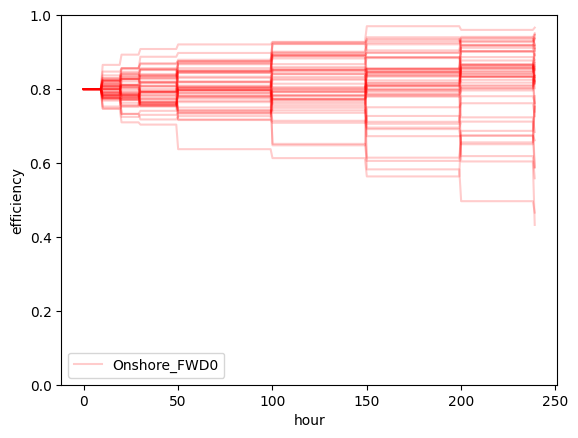

In [5]:
key = 'Onshore_FWD0'
label=key
tmp = results.get(key, forecast_timepoints=[10, 20, 30, 50, 100, 150, 200])
for i in range(50):
    plt.plot(tmp[:,i], '-r', alpha=0.2, label=label)
    label=None
plt.legend()
plt.ylim(0.0,1.0)
plt.xlabel('hour')
plt.ylabel('efficiency');

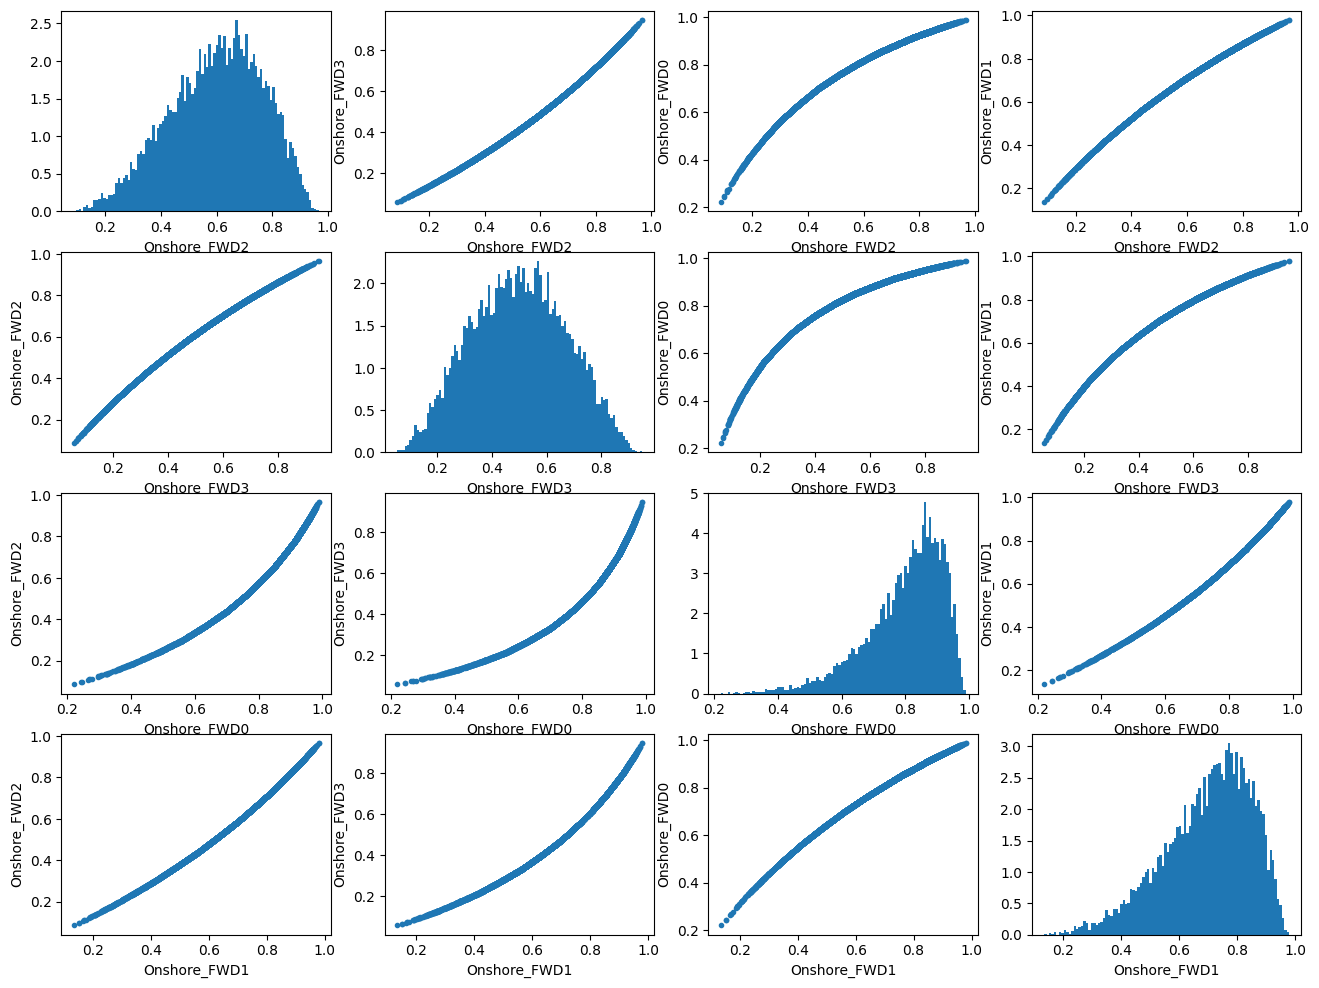

In [7]:
timepoint = -1
plt.figure(figsize=(16,12))
i=1
for k in results.keys():
    f1 = results.get(k)
    for l in results.keys():
        plt.subplot(4,4,i)
        f2 = results.get(l)
        if k==l:
            plt.hist(f1[timepoint], bins=100, label=k, density=True)
            plt.xlabel(k)
        else:
            plt.plot(f1[timepoint], f2[timepoint], '.')
            plt.xlabel(k)
            plt.ylabel(l)
        i += 1

# Multiregion Windpower Model

In [8]:
#wind = wind_forecast_model.simulate(timegrid, rnd)
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

In [94]:
days = 10
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-1] + i/(365.0*24.0) for i in range(4)]
rnd = np.random.normal(size=wind.rnd_shape(n_sims, timegrid.shape[0]))
results = wind.simulate(timegrid, rnd, expiries=forward_expiries, 
                                       initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                          'Offshore': [0.6, 0.6, 0.5, 0.5]}
                               )

In [97]:
results.keys()

{'Offshore_FWD0',
 'Offshore_FWD1',
 'Offshore_FWD2',
 'Offshore_FWD3',
 'Onshore_FWD0',
 'Onshore_FWD1',
 'Onshore_FWD2',
 'Onshore_FWD3',
 'Wind_Germany_FWD0',
 'Wind_Germany_FWD1',
 'Wind_Germany_FWD2',
 'Wind_Germany_FWD3'}

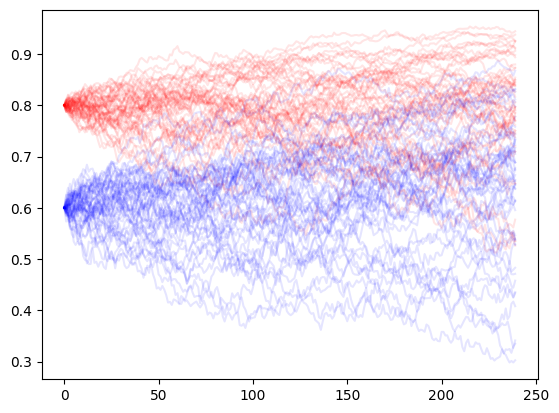

In [102]:
lines = ['-r', '-b']
for i,k in enumerate(['Onshore_FWD0', 'Offshore_FWD0']):
    tmp = results.get(k)#, forecast_timepoints=[10, 20])
    for j in range(50):
        plt.plot(tmp[:,j],lines[i], alpha=0.1)

# Residual Demand Forward Model

In [9]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.01, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rd_model = ResidualDemandForwardModel(wind_power_forecast=wind, highest_price_ou_model= highest_price, 
                                      supply_curve=supply_curve, max_price=1.0, power_name= 'Power_Germany')

In [10]:
rnd = np.random.normal(size=rd_model.rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))

In [11]:
rdm_result = rd_model.simulate(timegrid, rnd, expiries=forward_expiries, initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                          'Offshore': [0.6,0.6,0.6,0.6]})

In [11]:
rdm_result.get('Power_Germany:0', forecast_timepoints=[0,1,2])

array([[0.26666667, 0.26666667, 0.26666667, ..., 0.26666667, 0.26666667,
        0.26666667],
       [0.26021478, 0.27070423, 0.26975393, ..., 0.26509957, 0.26823855,
        0.26438372],
       [0.25406328, 0.27815923, 0.27138286, ..., 0.26864876, 0.26813227,
        0.27003154],
       ...,
       [0.28389246, 0.29749926, 0.24491791, ..., 0.28798642, 0.24734741,
        0.23657972],
       [0.28392222, 0.29742968, 0.24492363, ..., 0.28800452, 0.24734926,
        0.23654951],
       [0.28392685, 0.29743316, 0.24492425, ..., 0.28804524, 0.24733697,
        0.23655771]])

In [12]:
rd_model.udls()

{'Offshore', 'Onshore', 'Power_Germany', 'Wind_Germany'}

# PPA Hedging

In [14]:
results = {}
try:
    with open('hedge_results.json','r') as f:
        results = json.load(f)
except:
    pass
from rivapy.tools.interfaces import FactoryObject
def compute_pnl_figures(pricing_results):
    pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)
    return {'mean': pnl.mean, 'var': pnl.var, '1%':np.percentile(pnl,1),  '99%': np.percentile(pnl,99)}

def run_hedge_experiment(val_date, ppa_spec, model, **kwargs):
    params = {}
    params['ppa_spec'] = ppa_spec.to_dict()
    params['ppa_spec_hash'] = ppa_spec.hash()
    params['model'] = model.to_dict()
    params['model_hash'] = model.hash()
    params['pricing_param'] = kwargs
    hash_key = FactoryObject.hash_for_dict(params)
    #if hash_key in results:
    pricing_result =  GreenPPADeepHedgingPricer.price(val_date, 
                                  ppa_spec, 
                                  model,**kwargs)
    

In [28]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)
highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.01, mean_reversion_level=1.0)
#supply_curve = SmoothstepSupplyCurve(1.0, 0)
rd_model = LinearDemandForwardModel(wind_power_forecast=wind, x_volatility = 1.4, 
                                    x_mean_reversion_speed=2.0, 
                                    power_name= 'Power_Germany')

In [29]:
val_date = dt.datetime(2023,1,1)
strike = 0.3 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [6]:
pricing_results.hedge_model.save('depp')

INFO:tensorflow:Assets written to: depp/delta_model\assets


INFO:tensorflow:Assets written to: depp/delta_model\assets


In [11]:
model = DeepHedgeModel.load('depp')

In [30]:
pricing_results = run_hedge_experiment(val_date, 
                                      spec, 
                                      rd_model, 
                                        initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                            'Offshore': [0.6,0.6,0.6,0.6]},
                                       power_fwd_prices = [100, 100, 100, 100],
                                        forecast_hours=[10, 14, 18],
                                        additional_states=['Offshore'],
                                        depth=3, nb_neurons=32, n_sims=10_000, 
                                        regularization=0.0,
                                        epochs=200, 
                                       verbose=1,
                                        tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                        initial_lr=5e-4,
                                        decay_steps=8_000,
                                          batch_size=100, decay_rate=0.8, seed=42)

C:\Users\doeltz\development\RiVaPy\notebooks\models\../..\rivapy\tools\datetime_grid.py:24: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  self.dates = pd.date_range(start, end, freq=freq, tz=tz, closed=closed).to_pydatetime()


Epoch 1/200
100/100 [==============================] - 15s 17ms/step - loss: 190.4222
Epoch 2/200
100/100 [==============================] - 1s 15ms/step - loss: 0.8738
Epoch 3/200
100/100 [==============================] - 1s 9ms/step - loss: 0.8938
Epoch 4/200
100/100 [==============================] - 1s 10ms/step - loss: 0.8707
Epoch 5/200
 30/100 [========>.....................] - ETA: 1s - loss: 0.8245

KeyboardInterrupt: 

In [39]:
pricing_results.paths.keys()
#ttm

dict_keys(['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0'])

8/8 [==============================] - 0s 1ms/step


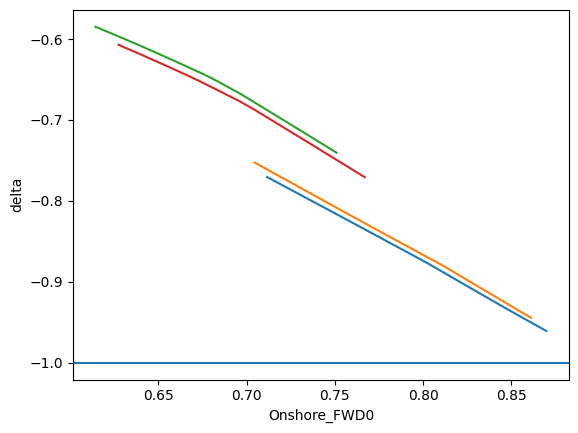

In [85]:
t = 48
p=10.0
projection = np.linspace(0.9,1.1, 250)
projected_key = 'Onshore_FWD0'
for selected in [2,5,100,400]:
#selected = 2
    #key = 'Power_Germany_FWD0'
    #x = np.percentile(pricing_results.paths[key][-1,:],p)
    #selected = np.abs(x-pricing_results.paths[key][-1,:]).argmin()
    paths = {}

    T = pricing_results.hedge_model.timegrid[-1]
    ttm = (T-pricing_results.hedge_model.timegrid[t])/T
    for k,v in pricing_results.paths.items():
        if k == projected_key:
            paths[k] = projection*v[t,selected]
            x = projection*v[t,selected]
        else:
            paths[k] = np.full(shape=(projection.shape[0]), fill_value=v[t,selected])
    delta = pricing_results.hedge_model.compute_delta(paths, ttm)   

    plt.plot(x, delta)
plt.xlabel(projected_key)
plt.axhline(-1.0)
plt.ylabel('delta');

## Path Plots

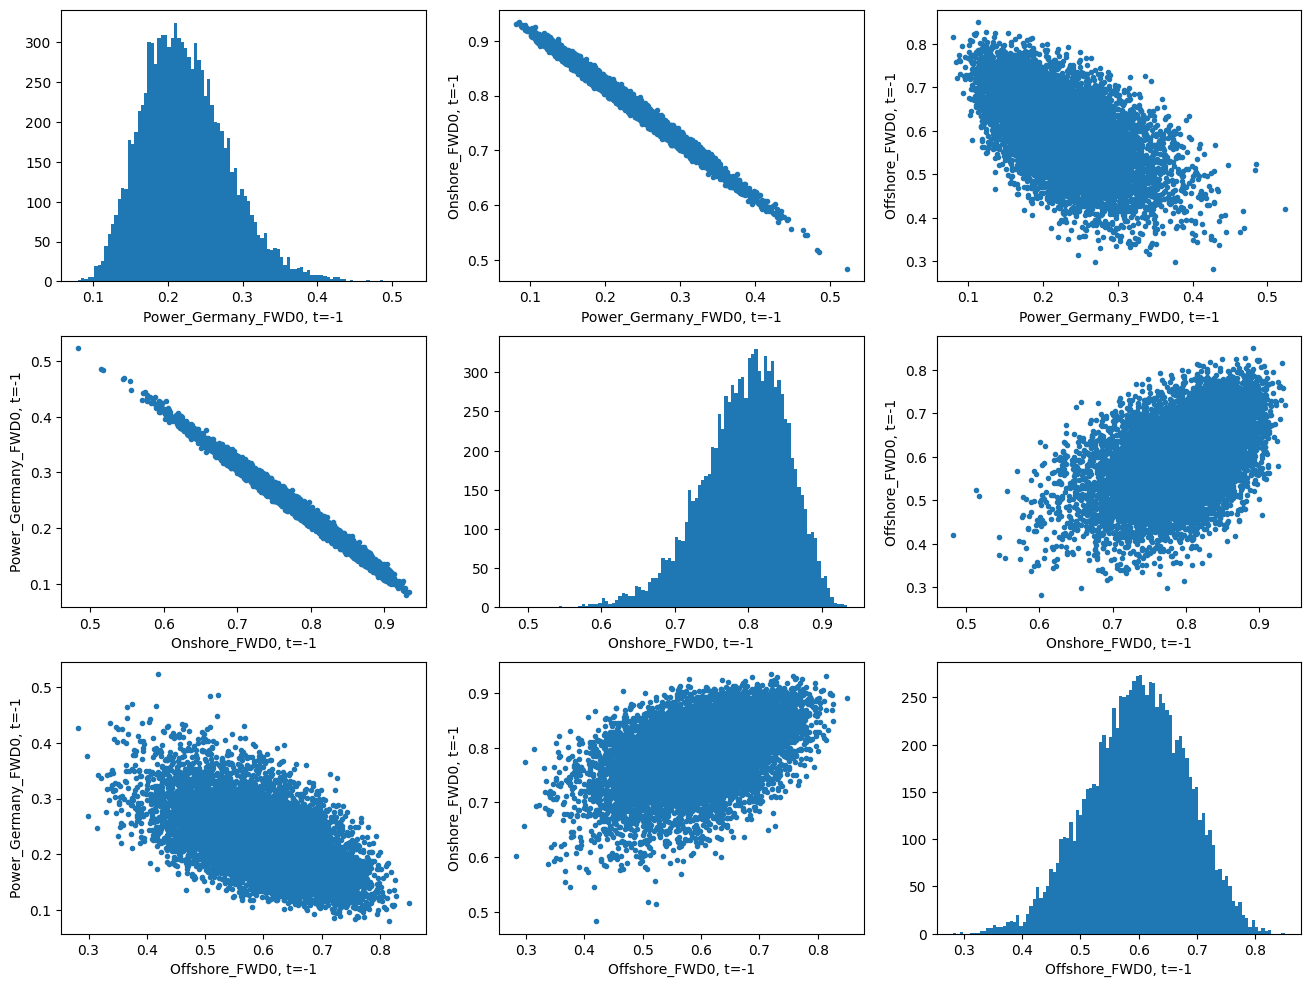

In [67]:
t = -1
plt.figure(figsize=(16,12))
n_x = 3
n_y = 3
i=1
for k,v in pricing_results.paths.items():
    for l,w in pricing_results.paths.items():
        plt.subplot(n_x,n_y,i)
        if k==l:
            plt.hist(v[t,:], bins=100)
            plt.xlabel(k+', t='+str(t))
        else:
            plt.plot(v[t,:], w[t,:], '.')
            plt.xlabel(k+', t='+str(t))
            plt.ylabel(l+', t='+str(t))
        i += 1

## Hedge PnL Distribution

313/313 [==============================] - 8s 4ms/step


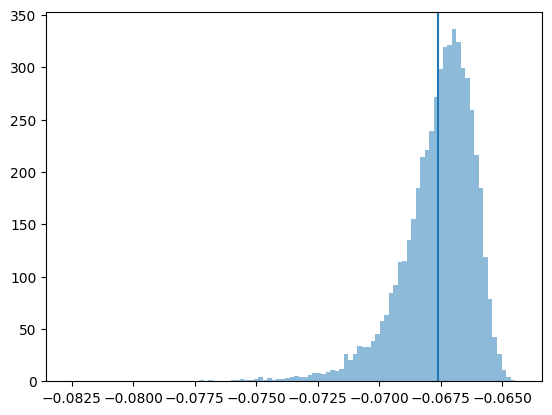

In [12]:
pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)

#plt.hist(pricing_results.payoff, bins=100, alpha=0.5, density=True)
plt.axvline(pnl.mean())
plt.hist(pnl,bins=100, alpha=0.5, density=True);

## Delta Plots

313/313 [==============================] - 1s 2ms/step


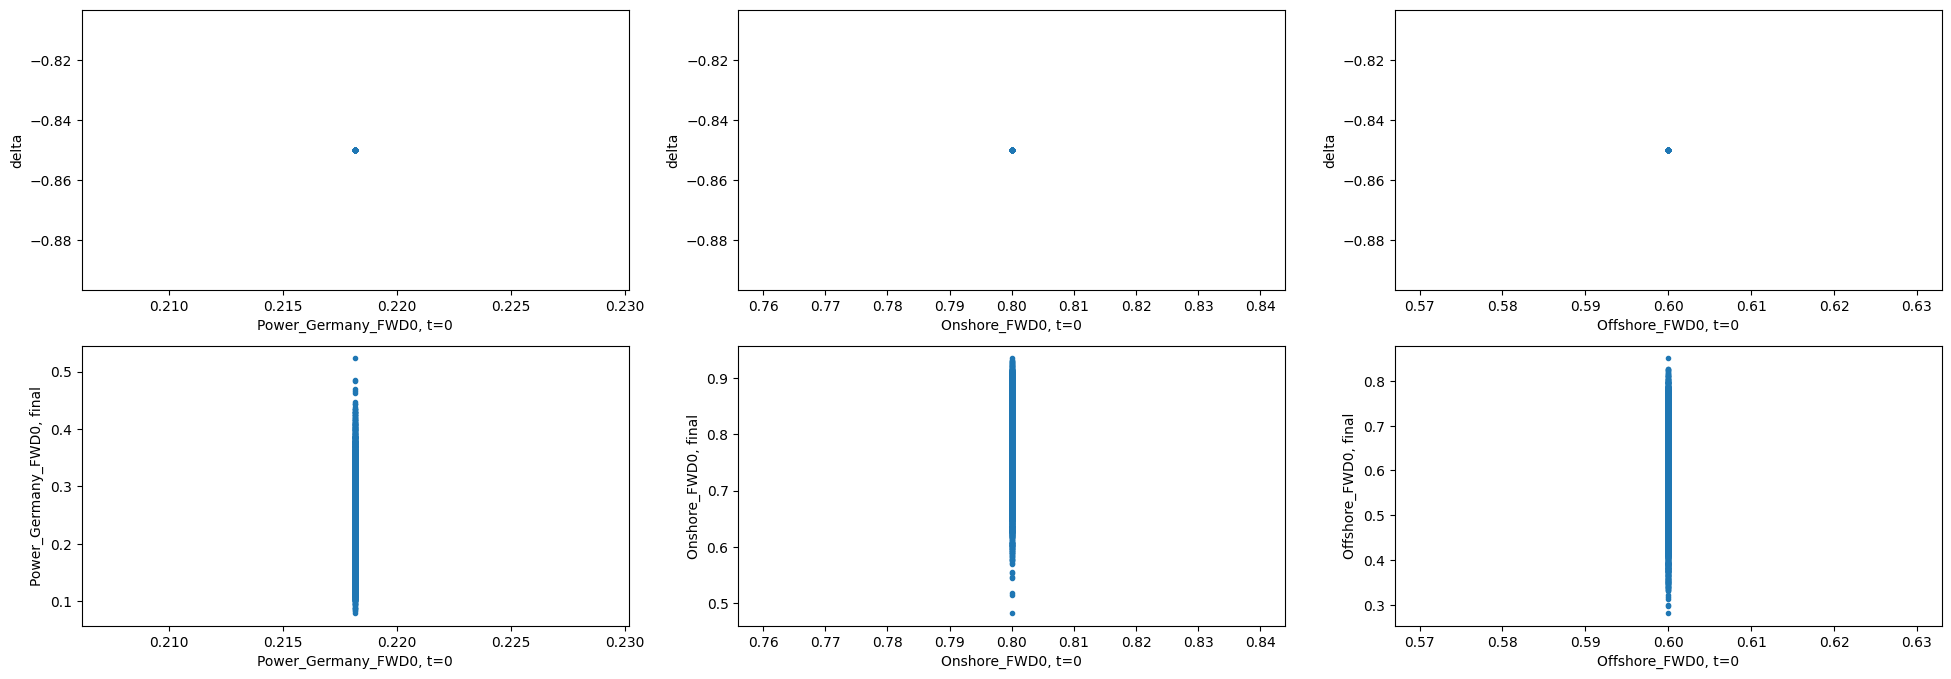

In [64]:
t = 0
n_x = 2
n_y = 3
plt.figure(figsize=(24,8))
delta = pricing_results.hedge_model.compute_delta(pricing_results.paths, t)
i=1
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], delta,'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel('delta')
    i+= 1
    
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], v[-1,:],'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel(k+', final')
    i+= 1